### Feature Selection methods from professor

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


plt.style.use('fivethirtyeight') 
mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['axes.labelsize'] = 14
# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

%matplotlib inline

In [86]:
df=pd.read_csv('train.csv')
all_data=df.copy(deep=True)
all_data_na = (all_data.isnull().sum(axis=0) / len(all_data)) * 100
from datetime import date
import datetime

df['Day'] = df['DATE'].apply(lambda x: 
                      (date(datetime.datetime.strptime(x,"%Y-%m-%d").year,datetime.datetime.strptime(x,"%Y-%m-%d").month,
                      datetime.datetime.strptime(x,"%Y-%m-%d").day)-date(2019,4,10)).days)
df.drop(['DATE'],axis=1,inplace=True)
target_variable='aircon_sum_target_next14d'
input_variables=df.columns[df.columns!=target_variable]
input_data=df.loc[:,input_variables]
input_variables


Index(['SITE_ID', 'CELL_TYPE_Macro', 'CELL_TYPE_Mobil', 'CELL_TYPE_TRP',
       'CELL_TYPE_Tx site', 'CELL_TYPE_micro', 'N_TRANSPORTED_SITES',
       'GEOGRAPHIC_CLUSTER_K_0', 'GEOGRAPHIC_CLUSTER_K_1',
       'GEOGRAPHIC_CLUSTER_K_2',
       ...
       'skew_fire/smoke_alarms_prev14d', 'skew_ge_alarms_prev14d',
       'skew_power_alarms_prev14d', 'skew_temperature_alarms_prev14d',
       'kurt_equipment_alarms_prev14d', 'kurt_fire/smoke_alarms_prev14d',
       'kurt_ge_alarms_prev14d', 'kurt_power_alarms_prev14d',
       'kurt_temperature_alarms_prev14d', 'Day'],
      dtype='object', length=135)

In [28]:
from sklearn.preprocessing import StandardScaler

X = input_data.loc[:,input_variables]
y = df.loc[:,target_variable]

seed = 1234

# let's create also a pandas data frame
#df = pd.DataFrame(data.data, columns=data.feature_names)
#df['MEDV'] = y
# scaler = MinMaxScaler()
# scaler.fit(X)
# X=scaler.transform(X)

scaler=StandardScaler()
Xs=scaler.fit_transform(X)


In [26]:
Xs.shape

(621300, 135)

### Baseline Performance

In [29]:
kfolds = KFold(10,shuffle=True,random_state=seed)

model = linear_model.LinearRegression()
scores = cross_val_score(model, X, y, cv=kfolds)

print("R2 Mean %.3f StdDev %.3f"%(scores.mean(),scores.std()))

R2 Mean 0.040 StdDev 0.010


### Reduced VAriance Feature Selection

In [32]:
feature_selection_variance_model = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_selected_features_variance = feature_selection_variance_model.fit_transform(X)


mask = feature_selection_variance_model.get_support() #list of booleans
print("Reduced data set shape = ", X_selected_features_variance.shape)
print("     Selected features = ", input_variables[mask])
print("      Deleted Features = ", input_variables[~mask])

Reduced data set shape =  (621300, 109)
     Selected features =  Index(['SITE_ID', 'N_TRANSPORTED_SITES', 'GEOGRAPHIC_CLUSTER_K_7',
       'mean_temperature_prev7d', 'max_temperature_prev7d',
       'min_temperature_prev7d', 'mean_temperature_prev3d',
       'max_temperature_prev3d', 'min_temperature_prev3d',
       'mean_rain_mm_prev7d',
       ...
       'ge_mean_persistance_prev3d', 'ge_min_persistance_prev3d',
       'power_max_persistance_prev3d', 'power_mean_persistance_prev3d',
       'power_min_persistance_prev3d', 'temperature_max_persistance_prev3d',
       'temperature_mean_persistance_prev3d',
       'temperature_min_persistance_prev3d', 'kurt_power_alarms_prev14d',
       'Day'],
      dtype='object', length=109)
      Deleted Features =  Index(['CELL_TYPE_Macro', 'CELL_TYPE_Mobil', 'CELL_TYPE_TRP',
       'CELL_TYPE_Tx site', 'CELL_TYPE_micro', 'GEOGRAPHIC_CLUSTER_K_0',
       'GEOGRAPHIC_CLUSTER_K_1', 'GEOGRAPHIC_CLUSTER_K_2',
       'GEOGRAPHIC_CLUSTER_K_3', 'GEOGRAPHI

Text(0.5, 1.0, 'Variable aircon_sum_wo_prev14d')

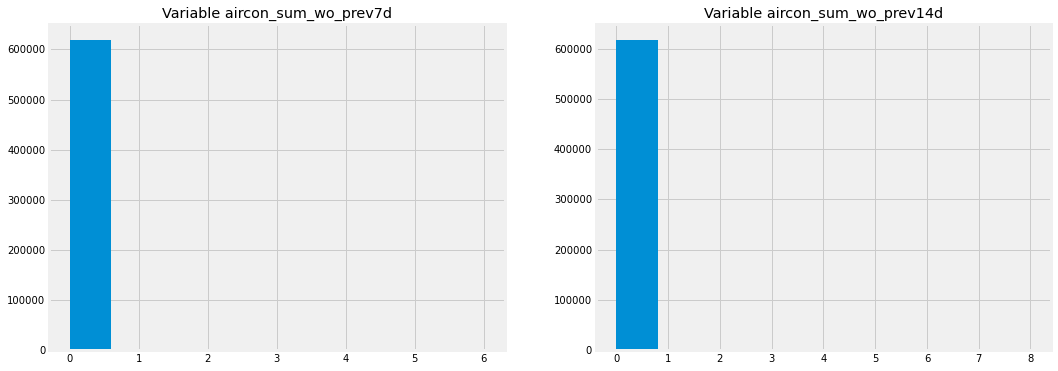

In [35]:
plt.subplots(1,2,figsize=(16,6))

plt.subplot(1,2,1)
plt.hist(df['aircon_sum_wo_prev7d'],label='aircon_sum_wo_prev7d')
plt.title("Variable aircon_sum_wo_prev7d")

plt.subplot(1,2,2)
plt.hist(df['aircon_sum_wo_prev14d'],label='aircon_sum_wo_prev14d')
plt.title("Variable aircon_sum_wo_prev14d")

In [37]:
variance_model = LinearRegression()
variance_scores = cross_val_score(variance_model, Xs[:,mask], y, cv=kfolds)
print("Variance Model R2 Mean %.3f StdDev %.3f"%(variance_scores.mean(),variance_scores.std()))

Variance Model R2 Mean 0.005 StdDev 0.001


### Univariate Feature Selection

In [40]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# apply the procedure to take the best k variables based on mutual_info_regression
feature_selection_univariate_model = SelectKBest(mutual_info_regression, k=4)


MemoryError: 

In [42]:
from numba import jit, cuda
# function optimized to run on gpu 
@jit(target ="cuda")
# fit the feature selection model and select the four variables
X_selected_features_univariate = feature_selection_univariate_model.fit_transform(Xs,y)

mask = feature_selection_univariate_model.get_support() #list of booleans
print("Reduced data set shape = ",X_selected_features_univariate.shape)
print("     Selected features = ",input_variables[mask])
print("      Deleted Features = ", input_variables[~mask])

MemoryError: 

In [ ]:
univariate_model = linear_model.LinearRegression()
univariate_scores = cross_val_score(univariate_model, Xs[:,mask], y, cv=kfolds)
print("Univariate Model R2 Mean %.3f StdDev %.3f"%(univariate_scores.mean(),univariate_scores.std()))

In [ ]:
mask = np.invert(mask)
univariate_model = linear_model.LinearRegression()
univariate_scores = cross_val_score(univariate_model, Xs[:,mask], y, cv=kfolds)
print("Univariate Model R2 Mean %.3f StdDev %.3f"%(univariate_scores.mean(),univariate_scores.std()))

## PCA

In [43]:
from sklearn.preprocessing import StandardScaler
full_pca_model = PCA()
X_std = StandardScaler().fit_transform(X)
full_fitted_model = full_pca_model.fit(X_std)

In [44]:
full_fitted_model.explained_variance_ratio_

array([1.38929468e-01, 8.44028662e-02, 6.25134768e-02, 4.79832642e-02,
       4.76701367e-02, 3.75849866e-02, 3.63472895e-02, 3.19402381e-02,
       2.79017928e-02, 2.24931623e-02, 1.97102200e-02, 1.85454105e-02,
       1.71296405e-02, 1.59220014e-02, 1.41907452e-02, 1.38071900e-02,
       1.35423620e-02, 1.25416019e-02, 1.15784998e-02, 1.11050413e-02,
       1.00329426e-02, 9.39082441e-03, 9.29072596e-03, 8.78965877e-03,
       8.70641355e-03, 8.62669099e-03, 8.49956238e-03, 8.25887339e-03,
       8.22324874e-03, 8.13784223e-03, 7.90898338e-03, 7.81011334e-03,
       7.76252460e-03, 7.68159717e-03, 7.49065275e-03, 7.35240072e-03,
       7.20419600e-03, 7.10642996e-03, 7.04894915e-03, 6.51567431e-03,
       6.49801881e-03, 6.47341165e-03, 6.19473407e-03, 6.07707635e-03,
       5.90481924e-03, 5.84572612e-03, 5.72636986e-03, 5.56302221e-03,
       5.36955905e-03, 5.19765497e-03, 4.97999934e-03, 4.81107842e-03,
       4.76379947e-03, 4.59851442e-03, 4.31457658e-03, 4.14137328e-03,
      

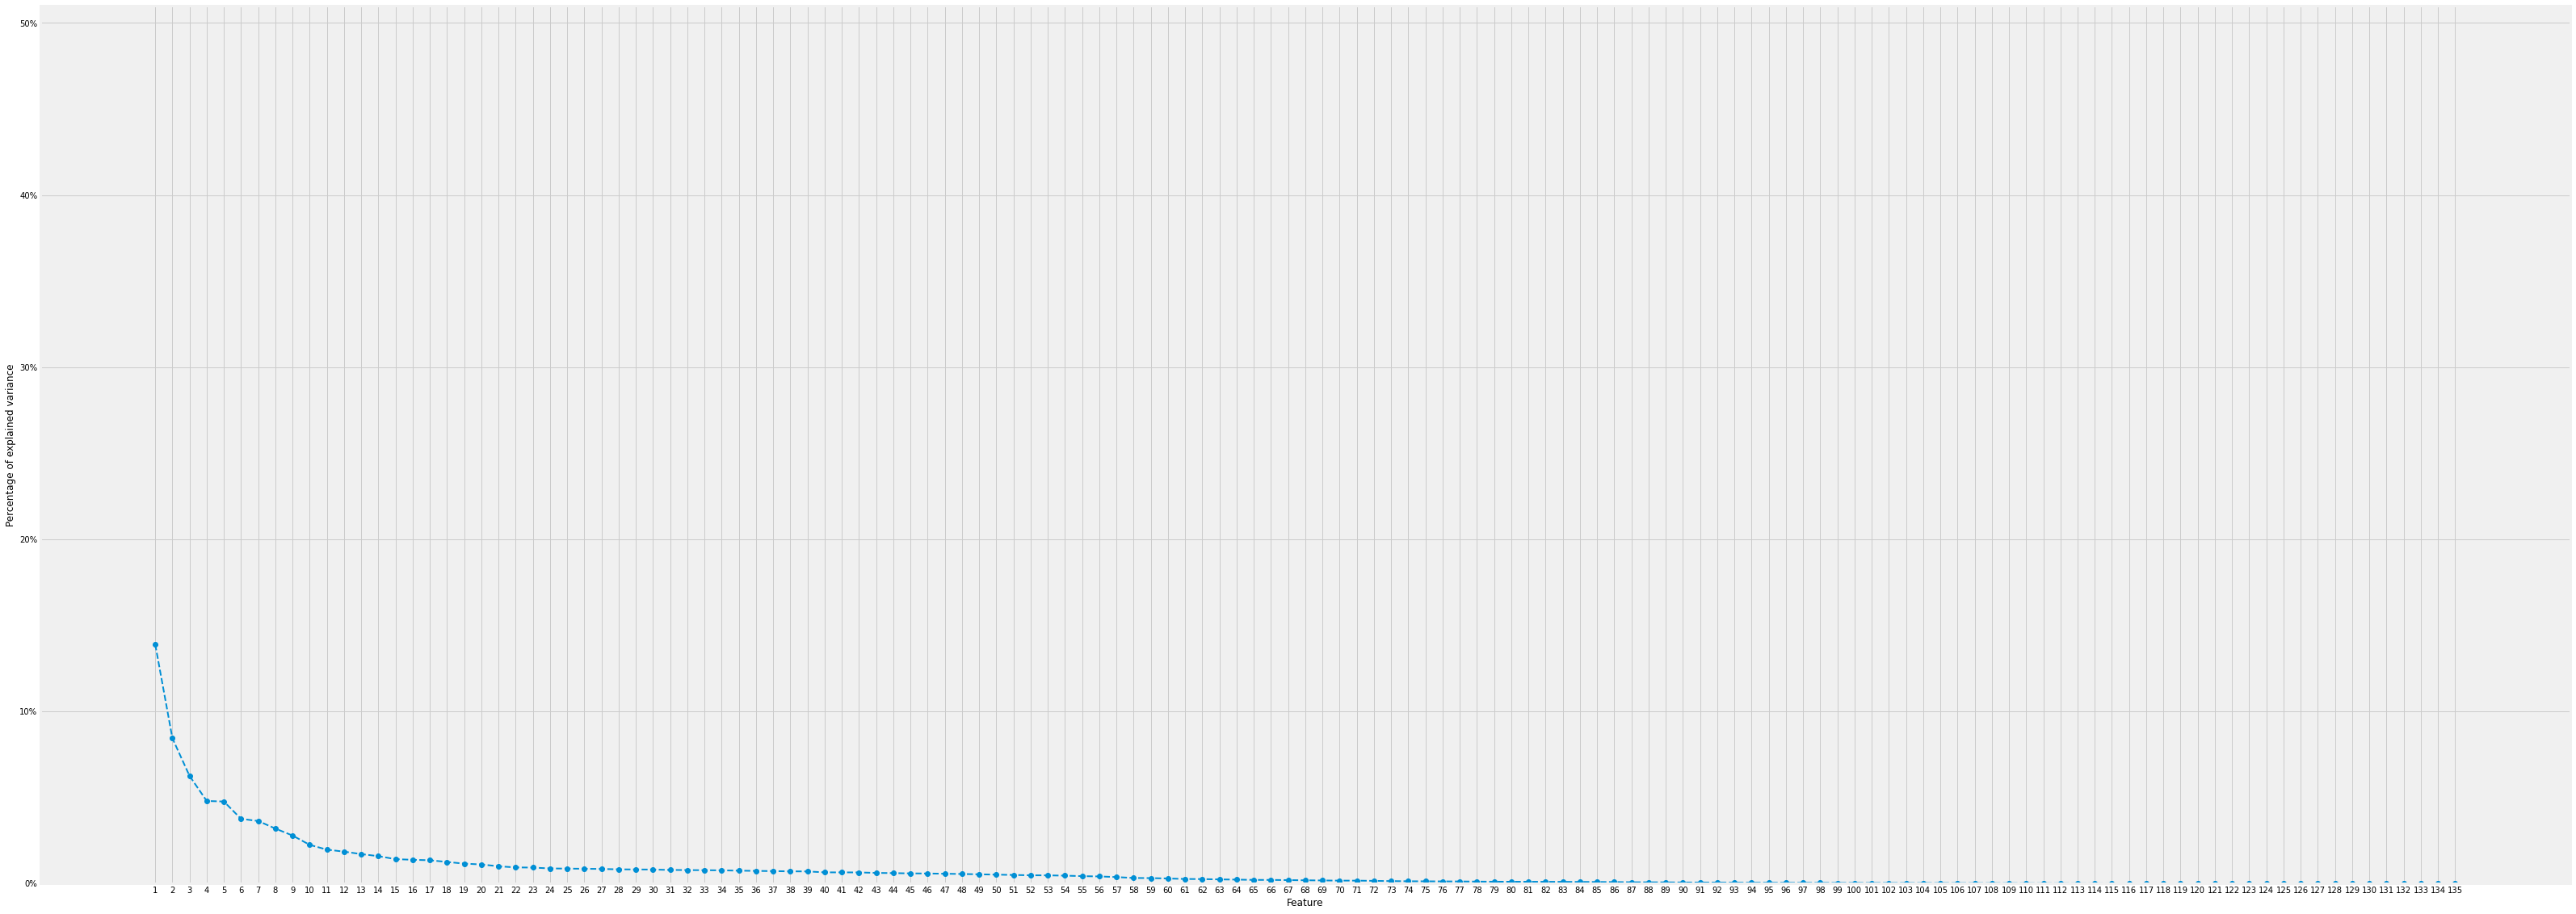

In [59]:
plt.figure(figsize=(50, 20));
plt.plot(full_fitted_model.explained_variance_ratio_, '--o');
plt.xticks(np.arange(0,135,1),labels=np.arange(1,136,1));
plt.xlabel("Feature");
plt.ylabel("Percentage of explained variance");
plt.xticks(np.arange(0,135,1),labels=np.arange(1,136,1));
plt.yticks(np.arange(0.0,0.51,.1),labels=["%.0f%%"%(x*100) for x in np.arange(0.0,0.51,.1)]);
plt.ylim([0.0,0.51]);


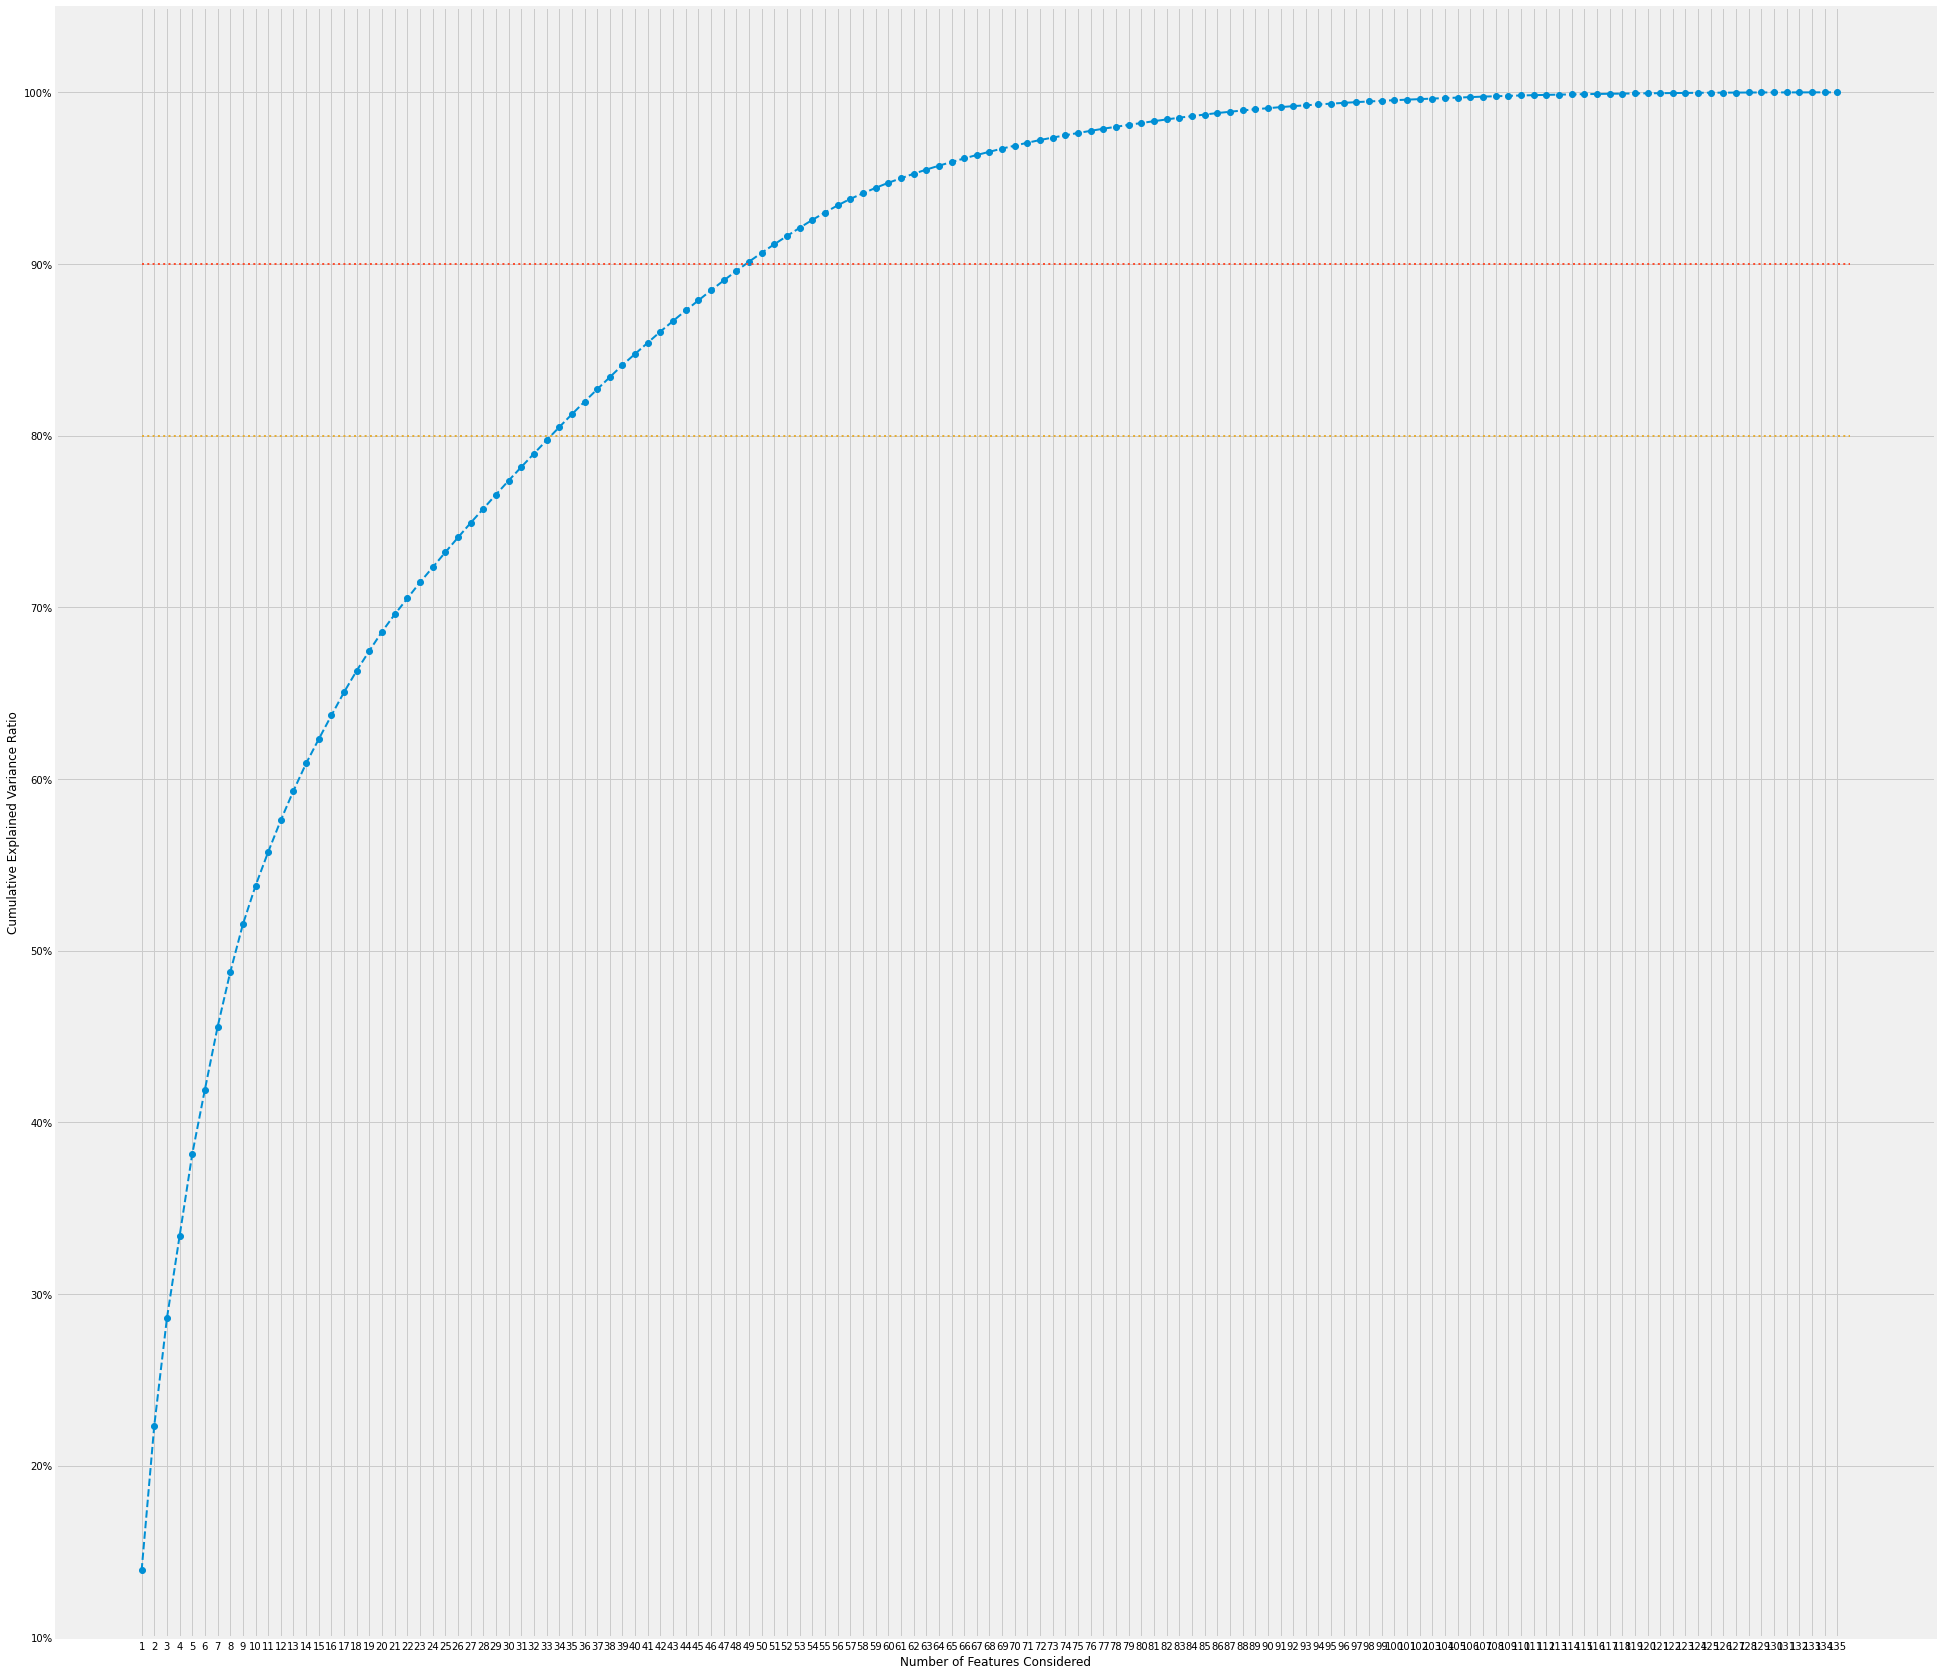

In [60]:
plt.figure(figsize=(30, 30));

plt.plot(full_fitted_model.explained_variance_ratio_.cumsum(), '--o');
plt.xticks(np.arange(0,135,1),labels=np.arange(1,136,1));
plt.yticks(np.arange(0.1,1.1,.1),labels=["%.0f%%"%(x*100) for x in np.arange(0.1,1.1,.1)]);
plt.ylim([0.1,1.05]);
plt.plot([0,135],[.9,.9],':');
plt.plot([0,135],[.8,.8],':');
plt.xlabel("Number of Features Considered");
plt.ylabel("Cumulative Explained Variance Ratio");


In [93]:
feature_selection_pca_model = PCA(n_components=100)
fitted_model = feature_selection_pca_model.fit(X_std)

X_selected_features_pca = fitted_model.transform(X_std)
print("    Explained Variance = %.3f" % fitted_model.explained_variance_ratio_.cumsum()[-1])
print("Reduced data set shape =",X_selected_features_pca.shape)

    Explained Variance = 0.995
Reduced data set shape = (621300, 100)


In [94]:
pca_model = linear_model.LinearRegression()
pca_scores = cross_val_score(pca_model, X_selected_features_pca, y, cv=kfolds)
pca_scores.mean()
print("PCA Model R2 Mean %.3f StdDev %.3f"%(pca_scores.mean(),pca_scores.std()))

PCA Model R2 Mean 0.040 StdDev 0.010


<Figure size 864x864 with 0 Axes>

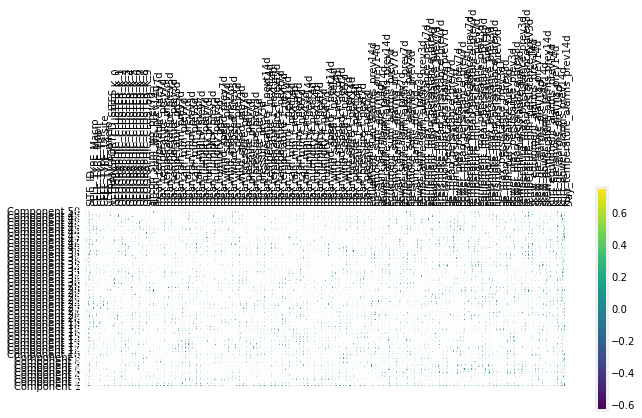

In [85]:
number_of_components = feature_selection_pca_model.components_.shape[0]
number_of_variables = feature_selection_pca_model.components_.shape[1]
component_ticks = np.arange(0,number_of_components,1)
component_labels = ['Component '+str(x+1) for x in component_ticks]

plt.figure(figsize=(12,12));
plt.matshow(feature_selection_pca_model.components_);

# avoid issue that cuts the first and last row 
plt.ylim(-0.5, len(feature_selection_pca_model.components_)-0.5)

plt.yticks(component_ticks, labels=component_labels);
plt.colorbar();
plt.grid(False);
plt.xticks(range(len(input_variables)),input_variables,rotation=90,ha='left');
for (i, j), z in np.ndenumerate(feature_selection_pca_model.components_):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',color="white");
plt.show();

In [75]:
feature_selection_pca_model.components_.shape

(50, 135)

In [79]:
X_std.shape

(621300, 135)